In [1]:
!pip install pretrainedmodels
!pip install pytorch-pretrained-bert

In [2]:
import numpy as np 
import pandas as pd 

from typing import *

import torch
import torch.optim as optim

import gc
gc.collect()

0

In [3]:
# Import fast ai 
import fastai

from fastai import *
from fastai.vision import *
from fastai.text import *

from torchvision.models import *
import pretrainedmodels

import sys

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback
from fastai.utils import *
from torch.utils import *
from sklearn.model_selection import train_test_split

In [4]:
from transformers import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    "bert-base-uncased"
)

I1113 21:41:04.560673 140407656929088 file_utils.py:39] PyTorch version 1.1.0 available.
I1113 21:41:04.582983 140407656929088 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I1113 21:41:06.002159 140407656929088 tokenization_utils.py:374] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/superceed1/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [5]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len
    
    def __call__(self, *args, **kwargs):
        return self
    
    def tokenizer(self, t:str) -> List[str]:
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [6]:
data_root = '../data/toxic_comment/cleaned/'

In [7]:
train_df = pd.read_csv(data_root + 'train.csv')
test_df = pd.read_csv(data_root + 'test.csv')

In [8]:
# split 8:2 ratio
train_df.fillna('no comment', inplace=True)
test_df.fillna('no comment', inplace=True)
train, val = train_test_split(
    train_df, shuffle=True, test_size=0.2, random_state=42
)

In [9]:
train.shape

(127656, 9)

In [10]:
# Wrap BERT VOCAB and BERT tokenizer with fast ai modules
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [11]:
fastai_tokenizer = Tokenizer(
    tok_func=FastAiBertTokenizer(
        bert_tok, max_seq_len=256
    ), pre_rules=[], post_rules=[]
)

In [12]:
# Lets create the databunch
# Note bert tokenizer and bert vocab used here
# Fill in some missing values here
label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

data_bunch_train = TextClasDataBunch.from_df(
    ".", train, val,
    tokenizer=fastai_tokenizer,
    vocab=fastai_bert_vocab,
    include_bos=False,
    include_eos=False,
    text_cols="comment_text",
    label_cols=label_columns,
    bs=13,
    collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
)

In [13]:
data_bunch_train.show_batch()

text,target
[CLS] if it is not genetic than what is it do wolves stop reg ##urg ##itating food once there are in captivity do ding ##os stop it why do other dog owners report reg ##urg ##itating and by the way the book from elizabeth marshall thomas was translated from english into german and i provided the original title which you obviously failed to notice you are the one who makes,
[CLS] from wikipedia ##re ##quest ##ed moves december rock band video game rock band there is no page at rock band or rock band as they are just red ##ire ##cts hence no reason for the video game at the end talk contributions actually there was an article at rock band until somebody decided to merge it a couple of weeks ago and that was not even a clear consensus,
[CLS] i have been working for some time on category ##rom ##an bridges but you certainly provide new info here this is what a web ##page says about the al ##con ##eta ##r bridge destroyed in the th century arches left moved in i hope they did not change the arch structure then here the most authoritative photo http ##user ##sser ##vic ##ios ##ret ##eca ##les ##jo ##mic ##oe ##al,
[CLS] block you have persistent ##ly criticized me personally in multiple discussions over the last couple weeks despite two warnings i am blocking you for hours please learn to con ##fine your commentary to the issues and not the people involved i have un ##block ##ed you since i have not seen any previous warning the di ##fs i have seen did not seem that bad and in any event,
[CLS] hmm ##mm i believe that most of the american churches have dropped the mission part of the title because it was simply was not true anymore the name is probably still in use in africa legally most of our american churches go by apostolic faith church with some churches adding the word trinity to distinguish our organization from others in regard to joe bishops sermon on biblical modest ##y,


In [14]:
# Load pretrained bert model from pytorch pretrained bert
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification, BertForNextSentencePrediction, BertForMaskedLM 

I1113 21:41:48.524676 140407656929088 modeling.py:230] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [15]:
bert_model_class = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=6
)

I1113 21:41:49.783385 140407656929088 modeling.py:580] loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/superceed1/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
I1113 21:41:49.788722 140407656929088 modeling.py:588] extracting archive file /home/superceed1/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmprj670r_9
I1113 21:41:52.426493 140407656929088 modeling.py:598] Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}


In [16]:
loss_func = nn.BCEWithLogitsLoss()

In [17]:
acc_02 = partial(accuracy_thresh, thresh=0.25)

In [18]:
model = bert_model_class

In [19]:
# Define learner function
from fastai.callback import *

learner = Learner(
    data_bunch_train, model,
    loss_func=loss_func, model_dir='model/', metrics=acc_02
)

In [20]:
# Below code will help us in splitting the model into desirable parts which will be helpful for us in Discriminative Learning i.e. setting up different learning rates and weight decays for different parts of the model.
def bert_class_split(self) -> List[nn.Module]:
    bert = model.bert
    embedder = bert.embeddings
    pooler = bert.pooler
    encoder = bert.encoder
    classifier = [model.dropout, model.classifier]
    n = len(encoder.layer) // 3
    print(n)
    groups = [[embedder], list(encoder.layer[:n]), list(encoder.layer[n+1:2*n]), list(encoder.layer[(2*n)+1:]), [pooler], classifier]
    return groups

In [21]:
x = bert_class_split(model)

4


In [22]:
learner.split(
    [x[0], x[1], x[2], x[3], x[5]]
)

Learner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
[CLS] grandma terri should burn in trash grandma terri is trash i hate grandma terri fk her to hell [SEP],[CLS] may utc it would be easiest if you were to admit to being a member of the involved portuguese lodge and then there would be no requirement to acknowledge whether you had a previous account carlos bot ##el ##ho did not have a good record or not and i would then remove the sock ##pu ##ppet template as irrelevant w ##pc ##oi permit is people to edit those articles such as ms ##ja ##pan does but just means you have to be more careful in ensuring that references back your edit is and that np ##ov is upheld [SEP],[CLS] the object ##ivity of this discussion is doubtful none ##xi ##sten ##t as indicated earlier the section on marxist leaders views is misleading a it lays un ##war ##rant ##ed and excessive emphasis on tr ##ots ##ky creating the misleading impression that other prominent marxist ##s marx eng #

In [23]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


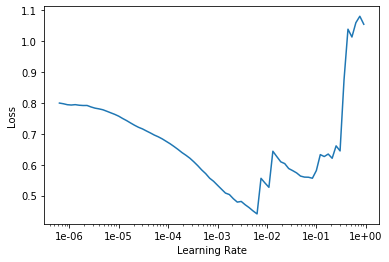

In [24]:
learner.recorder.plot()

In [25]:
learner.fit_one_cycle(
    2,max_lr=slice(1e-5, 5e-4), moms=(0.8, 0.7), pct_start=0.2,
    wd=(1e-7, 1e-5, 1e-4, 1e-3, 1e-2)
)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.063386,0.056259,0.979912,32:55
1,0.039420,0.045312,0.979305,39:44


In [26]:
learner.save('head')
learner.load('head')

Learner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
[CLS] grandma terri should burn in trash grandma terri is trash i hate grandma terri fk her to hell [SEP],[CLS] may utc it would be easiest if you were to admit to being a member of the involved portuguese lodge and then there would be no requirement to acknowledge whether you had a previous account carlos bot ##el ##ho did not have a good record or not and i would then remove the sock ##pu ##ppet template as irrelevant w ##pc ##oi permit is people to edit those articles such as ms ##ja ##pan does but just means you have to be more careful in ensuring that references back your edit is and that np ##ov is upheld [SEP],[CLS] the object ##ivity of this discussion is doubtful none ##xi ##sten ##t as indicated earlier the section on marxist leaders views is misleading a it lays un ##war ##rant ##ed and excessive emphasis on tr ##ots ##ky creating the misleading impression that other prominent marxist ##s marx eng #

In [27]:
learner.freeze_to(-2)
learner.fit_one_cycle(
    2, max_lr=slice(1e-5, 5e-4), moms=(0.8,0.7), pct_start=0.2, 
    wd=(1e-7, 1e-5, 1e-4, 1e-3, 1e-2)
)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.035256,0.048823,0.980250,24:55
1,0.045283,0.045386,0.979050,22:23


In [28]:
learner.save('head-2')
learner.load('head-2')

Learner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
[CLS] grandma terri should burn in trash grandma terri is trash i hate grandma terri fk her to hell [SEP],[CLS] may utc it would be easiest if you were to admit to being a member of the involved portuguese lodge and then there would be no requirement to acknowledge whether you had a previous account carlos bot ##el ##ho did not have a good record or not and i would then remove the sock ##pu ##ppet template as irrelevant w ##pc ##oi permit is people to edit those articles such as ms ##ja ##pan does but just means you have to be more careful in ensuring that references back your edit is and that np ##ov is upheld [SEP],[CLS] the object ##ivity of this discussion is doubtful none ##xi ##sten ##t as indicated earlier the section on marxist leaders views is misleading a it lays un ##war ##rant ##ed and excessive emphasis on tr ##ots ##ky creating the misleading impression that other prominent marxist ##s marx eng #

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.74E-06


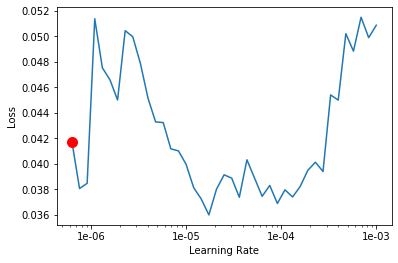

In [29]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [30]:
learner.fit_one_cycle(2, slice(5e-6, 5e-5), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.045203,0.044993,0.980335,35:07
1,0.037312,0.043990,0.980684,32:54


In [31]:
learner.save('head-3')
learner.load('head-3')

Learner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
[CLS] grandma terri should burn in trash grandma terri is trash i hate grandma terri fk her to hell [SEP],[CLS] may utc it would be easiest if you were to admit to being a member of the involved portuguese lodge and then there would be no requirement to acknowledge whether you had a previous account carlos bot ##el ##ho did not have a good record or not and i would then remove the sock ##pu ##ppet template as irrelevant w ##pc ##oi permit is people to edit those articles such as ms ##ja ##pan does but just means you have to be more careful in ensuring that references back your edit is and that np ##ov is upheld [SEP],[CLS] the object ##ivity of this discussion is doubtful none ##xi ##sten ##t as indicated earlier the section on marxist leaders views is misleading a it lays un ##war ##rant ##ed and excessive emphasis on tr ##ots ##ky creating the misleading impression that other prominent marxist ##s marx eng #

In [32]:
text = 'you are so sweet'
learner.predict(text)

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0.]),
 tensor([4.0619e-02, 2.0407e-05, 2.1858e-03, 4.0995e-04, 3.2507e-03, 1.0345e-03]))

In [33]:
text = 'you are pathetic piece of shit'
learner.predict(text)

(MultiCategory toxic;obscene;insult,
 tensor([1., 0., 1., 0., 1., 0.]),
 tensor([0.9939, 0.2122, 0.9616, 0.0284, 0.8392, 0.1226]))

In [34]:
learner.export()